<p style = "background-color : #0090ff; border-radius: 5px 5px; padding : 15px"><strong>

# АНАЛИЗ ЭФФЕКТИВНОСТИ ДВУХ ВАРИАНТОВ ПОСАДОЧНОЙ СТРАНИЦЫ

<p style = "background-color : #0090ff; border-radius: 5px 5px; padding : 15px"><strong>



<div class='alert alert-info'>

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта и провела A/B-тестирование. В результате эксперимента были собраны данные — скачайте их по ссылке ниже.

**Задача:**
Проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям — конверсии покупки и ежедневному среднему чеку.

**Признаки:**

- user_id — идентификатор пользователя, зашедшего на сайт;
- data — дата посещения сайта;
- group — группа теста (контрольная — А или тестовая — B);
- purchase — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
- price — цена купленного тура (если покупка не состоялась, цена равна 0).

In [1]:
# Загрузка необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro, ttest_ind, norm, t

In [2]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


<p style = "background-color : #0090ff; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">1. Анализ структуры данных и проведение предобработки: </span>


In [3]:
# исследуем структуру данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [4]:
# преобразуем столбцы к необходимым типам данных
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [5]:
# убедимся в одинаковой длительности проведения A/B-тестирования в каждой из групп
period = data.groupby(by='group')['date'].max() - data.groupby(by='group')['date'].min()
period

group
A   22 days
B   22 days
Name: date, dtype: timedelta64[ns]

In [6]:
# Проверем данные на наличие пропусков
data.isna().sum()

user_id     0
date        0
group       0
purchase    0
price       0
dtype: int64

In [7]:
# Проверем, есть ли пользователи, которые в процессе A/B-теста попали в обе группы.
def filter_cross_group_users(data, group_col='group', user_col='user_id'):
    """
    Функция проверки пользователей попавших в обе группы
    """
    # Находим пользователей в обеих группах
    group_a = set(data.loc[data[group_col] == 'A', user_col])
    group_b = set(data.loc[data[group_col] == 'B', user_col])
    
    cross_users = group_a & group_b 
    
    if cross_users:
        print(f'Пользователи попавшие в обе группы: {list(cross_users)}')
        print(f'Количество таких пользователей: {len(cross_users)}')
    else:
        print('Нет пользователей, попавших в обе группы')
    
    # Фильтруем данные
    filtered_data = data[~data[user_col].isin(cross_users)]
    
    print(f'Исходный размер данных: {data.shape[0]}')
    print(f'Размер после фильтрации: {filtered_data.shape[0]}')
    
    return filtered_data

# Почистим
filtered_data = filter_cross_group_users(data)

Пользователи попавшие в обе группы: [843786, 868364, 737298, 843797, 630805, 843802, 761882, 933918, 688167, 827432, 835630, 860206, 778288, 843832, 802877, 745536, 663619, 680003, 811077, 811079, 639059, 720982, 630871, 835673, 835675, 630887, 721002, 761965, 639090, 819318, 786565, 778375, 712853, 868503, 934040, 671902, 811196, 934076, 770242, 917708, 680144, 811222, 893145, 631008, 712930, 852215, 778488, 884985, 901376, 663810, 827654, 917767, 688390, 942353, 860441, 745756, 721188, 917799, 942375, 844083, 721208, 680251, 655678, 704832, 835905, 696642, 803145, 639310, 844114, 737626, 827741, 942436, 704870, 754022, 909678, 786808, 909688, 639366, 737675, 844173, 680343, 778649, 885146, 639386, 770459, 713119, 639407, 803248, 917936, 737712, 754102, 795063, 688568, 647609, 917949, 901567, 647615, 762307, 778692, 680390, 696791, 745943, 664025, 664030, 844263, 811497, 836084, 655860, 680436, 778743, 918023, 942600, 860683, 729611, 795157, 934424, 877083, 934436, 631337, 934444, 639

<p style = "background-color : #0090ff; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">2. Первичный анализ результатов A/B-тестирования: </span>



In [8]:
# Рассчитаем вспомогательные показатели для контрольной и тестовой групп
group_data = filtered_data.groupby(by='group').agg({
    'user_id':'count', # количество посещений сайта
    'purchase': 'sum', # суммарное количество совершённых покупок
    'price':'sum'      # сумма всех покупок
}).reset_index().rename(columns={
    'user_id':'user_count',
    'purchase': 'purchase_sum',
    'price':'price_sum'
})

group_data

,group,user_count,purchase_sum,price_sum
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


<div class="alert alert-success">
Выборки сбалансированы, а количество посещений обоих вариантов посадочной страницы сопоставимо.

In [9]:
# В каждой из групп рассчитаем ключевые показатели:
# конверсия
group_data['conversion'] = (group_data['purchase_sum'] / group_data['user_count'])*100
# средний чек
group_data['mean_receipt'] = (group_data['price_sum'] / group_data['purchase_sum'])*100

group_data

,group,user_count,purchase_sum,price_sum,conversion,mean_receipt
0,A,145307,17487,1417780000,12.034520,8.107623e+06
1,B,145381,17290,1533010000,11.892888,8.866455e+06


<div class="alert alert-success">
Конверсия группы А выглядит эффективней,а средний чек у группы В выше.

In [10]:
# Сравним варианты A/B по покупательской способности каждого из туров.
# Соберем туры
tour_dict = {
     100000: 'Тайланд',
     60000: 'Турция',
     200000: 'Мальдивы',
     10000: 'Санкт-Петербург',
     150000: 'Камчатка',
}
# Сделаем копию
t_data = data.copy()

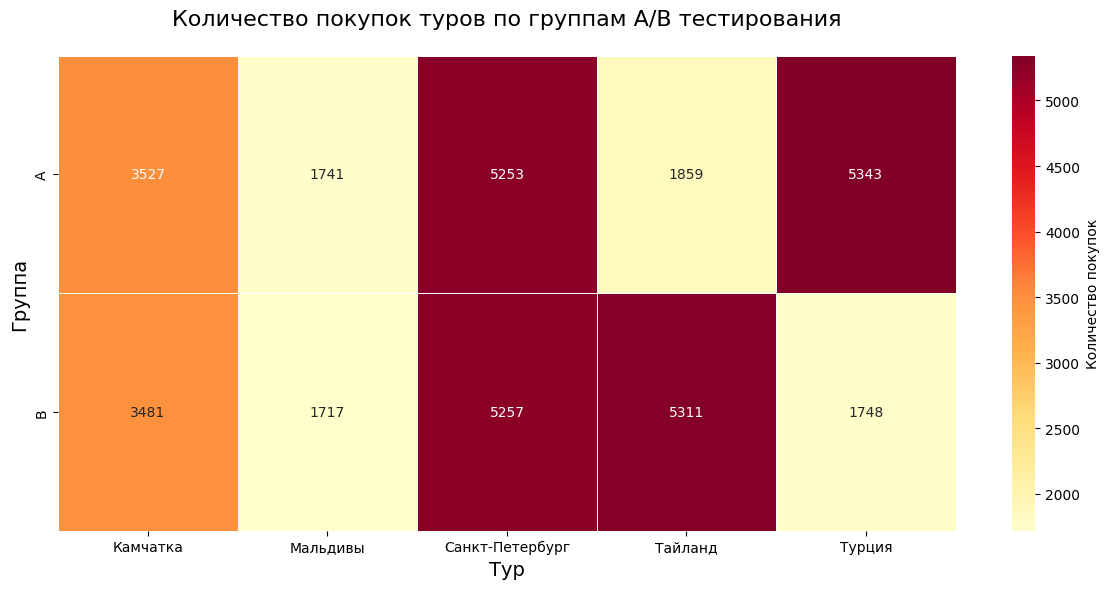

In [11]:
# построим сводную таблицу
cross_tab = pd.crosstab(
    index=t_data.loc[t_data['price'] != 0, 'group'],
    columns=t_data.loc[t_data['price'] != 0, 'price'].map(tour_dict),
    values=t_data.loc[t_data['price'] != 0, 'purchase'],
    aggfunc='sum'
)

# Визуализируем полученную сводную таблицу
plt.figure(figsize=(12, 6))
sns.heatmap(cross_tab, 
            annot=True, 
            fmt='.0f',
            cmap='YlOrRd', 
            linewidths=0.5,
            cbar_kws={'label': 'Количество покупок'})

plt.title('Количество покупок туров по группам A/B тестирования', pad=22, fontsize=16)
plt.xlabel('Тур', fontsize=14)
plt.ylabel('Группа', fontsize=14)
plt.tight_layout()
plt.show()

<div class="alert alert-success">
Исходя из тепловой диаграммы можно сделать селедующие выводы:
Ярко выраженное различие в Турах Тайланда и Турции! Покупательская сопсобность у участников группы В выше в Тайланде, а в Турции преобладает группа А.
Что касается Камчатки, Мальдив и Санкт-Петербурга то покупательская способность у групп не отличается.

<p style = "background-color : #0090ff; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">3. Проанализируем данные на предмет стабилизации метрик: </span>

In [12]:
# Рассчитаем вспомогательные показатели для контрольной и тестовой групп
date_group_data = filtered_data.groupby(by=['date','group']).agg({
    'user_id':'count', # количество посещений страницы
    'purchase': 'sum', # количество покупок
    'price':'sum'      # сумма покупок
}).reset_index().rename(columns={
    'user_id':'user_count',
    'purchase': 'purchase_sum',
    'price':'price_sum'
})

In [13]:
# ежедневной конверсии
date_group_data['conversion'] = (date_group_data['purchase_sum'] / date_group_data['user_count'])*100
# ежедневном среднем чеке
date_group_data['mean_receipt'] = (date_group_data['price_sum'] / date_group_data['purchase_sum'])*100

In [14]:
# Рассчитаем кумулятивные показатели
# кумулятивное количество посещений страницы;
date_group_data.loc[:, 'cum_user_count'] = date_group_data['user_count'].cumsum()
# кумулятивное количество покупок;
date_group_data.loc[:, 'cum_purchase_sum'] = date_group_data['purchase_sum'].cumsum()
# кумулятивную сумму покупок.
date_group_data.loc[:, 'cum_price_sum'] = date_group_data['price_sum'].cumsum()

In [15]:
# вычислим кумулятивную конверсию и кумулятивный средний чек.
# ежедневной конверсии
date_group_data['cum_conversion'] = (date_group_data['cum_purchase_sum'] / date_group_data['cum_user_count'])*100
# ежедневном среднем чеке
date_group_data['cum_mean_receipt'] = (date_group_data['cum_price_sum'] / date_group_data['cum_purchase_sum'])*100

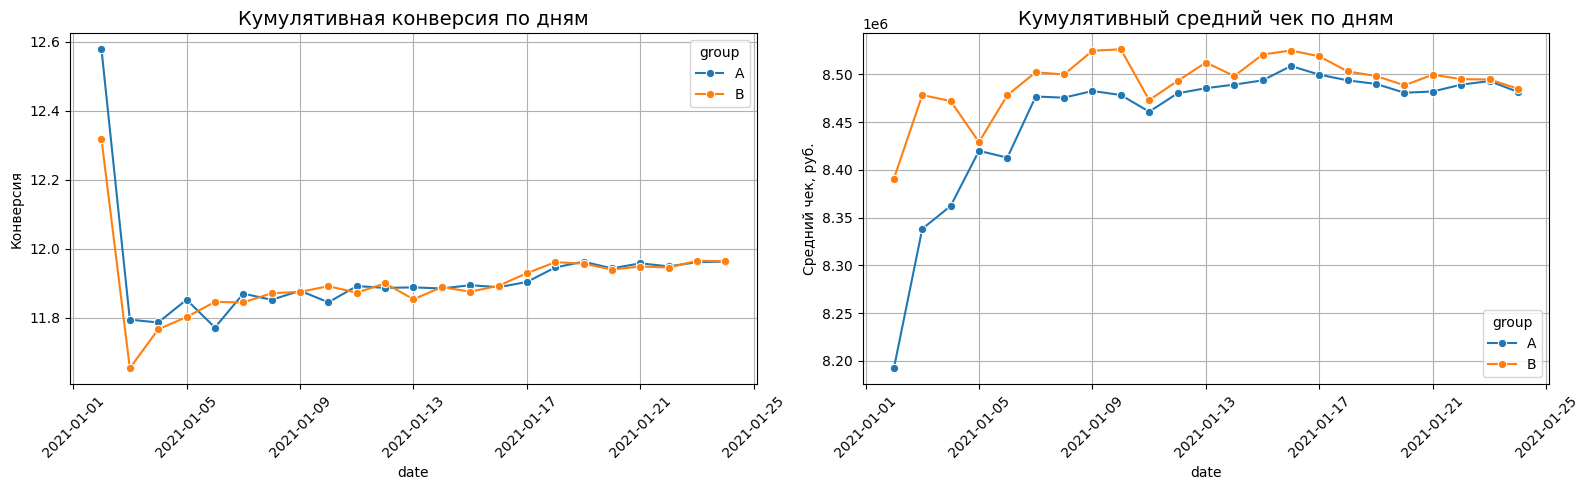

In [16]:
# Построем кумулятивные графики конверсии и среднего чека в каждой группе по дням
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Конверсии
sns.lineplot(x='date', y='cum_conversion', data=date_group_data, hue='group', ax=ax1, marker='o')
ax1.set_title('Кумулятивная конверсия по дням', fontsize=14)
ax1.set_ylabel('Конверсия')
ax1.xaxis.set_tick_params(rotation=45)
ax1.grid(True)

# Средний чек
sns.lineplot(x='date', y='cum_mean_receipt', data=date_group_data, hue='group', ax=ax2, marker='o')
ax2.set_title('Кумулятивный средний чек по дням', fontsize=14)
ax2.set_ylabel('Средний чек, руб.')
ax2.xaxis.set_tick_params(rotation=45)
ax2.grid(True)

plt.tight_layout()
plt.show()

<div class="alert alert-success">
Исходя из полученных графиков можно считать тест завершенных, обе метрики стабилизировалисть (Конверсия примерно с 2021-01-11 с незначительными далее колебаниями, а средний чек в районе 2021-01-15 и дальше также идут мелкие колебания).
В целом после стабилизации, конверсия она плюс минус одинаковая у обоих групп, а средний чек выше у группы В. 

<p style = "background-color : #0090ff; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">4. Проведём статистический анализ результатов A/B-тестирования: </span>


<div class='alert alert-info'>

**Гипотеза 1:**

**Основное предположение (H0)**: Новая группа B не лучше и не хуже группы A - конверсии равны.

**Альтернативное предположение (H1)**: Между группами есть реальная разница в конверсиях - не равны.

Будем использолвать **Z-тест** - стандартный статистический инструмент для оценки значимости различий в конверсиях.

In [17]:
cum_hypothesis= filtered_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)

cum_hypothesis

,sum,count
group,,
A,17487,145307
B,17290,145381


In [18]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=cum_hypothesis['sum'], #число «успехов»
    nobs=cum_hypothesis['count'], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


<div class="alert alert-success">
Т.е. разницы между А и В нет

<div class='alert alert-info'>

**Гипотеза 2:**


**Основное предположение (H0)**: Новая группа B не лучше и не хуже группы A - ежедневные средние чеки равны.

**Альтернативное предположение (H1)**: Между группами есть реальная разница в конверсиях - ежедневные средние чеки не равны.

In [19]:
receipt_hypothesis= date_group_data.groupby('group')['mean_receipt'].agg(
    ['mean', 'median']
)

receipt_hypothesis

,mean,median
group,,
A,8.096929e+06,8.192201e+06
B,8.857572e+06,8.777094e+06


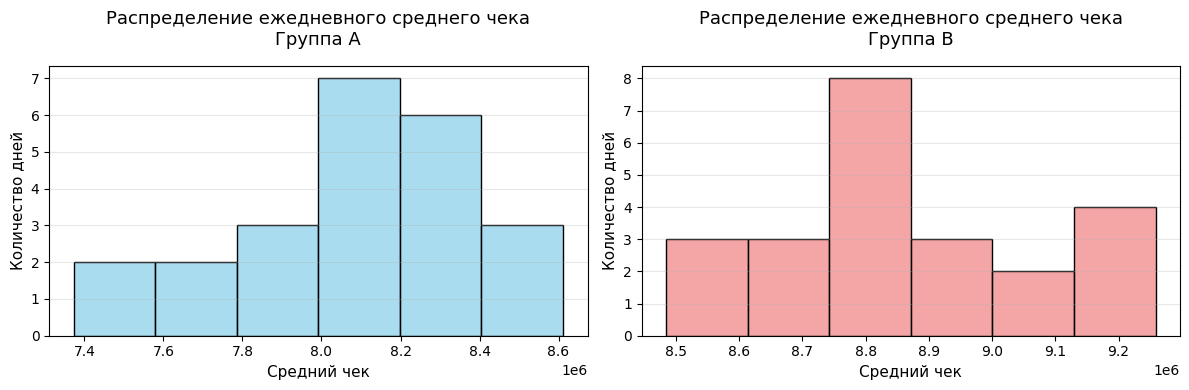

In [20]:
# Создаём композицию графиков
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Строим распределения среднего чека по группам
sns.histplot(data=date_group_data[date_group_data['group'] == 'A'], 
             x='mean_receipt', ax=axes[0], color='skyblue', alpha=0.7)
sns.histplot(data=date_group_data[date_group_data['group'] == 'B'], 
             x='mean_receipt', ax=axes[1], color='lightcoral', alpha=0.7)

# Настраиваем оформление графиков
axes[0].set_title('Распределение ежедневного среднего чека\nГруппа A', fontsize=13, pad=15)
axes[1].set_title('Распределение ежедневного среднего чека\nГруппа B', fontsize=13, pad=15)

# Добавляем подписи осей
for ax in axes:
    ax.set_xlabel('Средний чек', fontsize=11)
    ax.set_ylabel('Количество дней', fontsize=11)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

<div class="alert alert-success">
Распределения выглядят близко к нормальному, касательно среднего чека, то в группе В кажется выше.

In [21]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(date_group_data[date_group_data['group'] == 'A']['mean_receipt'])
shapiro_result_b = shapiro(date_group_data[date_group_data['group'] == 'B']['mean_receipt'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределение в группе А является нормальным
Принимаем нулевую гипотезу. Распределение в группе B является нормальным


<div class='alert alert-info'>
Исходя из подтверждения нормальности распределения при помощи теста Шапиро - Уилка, будем использовать Т-тест.

In [22]:
alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=date_group_data[date_group_data['group'] == 'A']['mean_receipt'],
    b=date_group_data[date_group_data['group'] == 'B']['mean_receipt'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


<div class="alert alert-success">
Полученные результаты дают нам понять, что разница между чеками А и В статически значима!

<div class='alert alert-info'>
Построим 95 % доверительный интервал для конверсий в каждой из групп

In [23]:
# фильтруем данные группы А
a_data = filtered_data[filtered_data['group'] == 'A']
# фильтруем данные группы B
b_data = filtered_data[filtered_data['group'] == 'B']

In [24]:
def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

In [25]:
# строим доверительный интервал для конверсии в группе А
lower_bound_a, upper_bound_a  = proportion_conf_interval(
    x_p=filtered_data['purchase'].mean(), # выборочная пропорция
    n=filtered_data['user_id'].count() # размер выборки
)

# строим доверительный интервал для конверсии в группе B
lower_bound_b, upper_bound_b  = proportion_conf_interval(
    x_p=b_data['purchase'].mean(), # выборочная пропорция
    n=b_data['user_id'].count() # размер выборки
)

# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (11.85, 12.08)
Доверительный интервал для конверсии в группе B: (11.73, 12.06)


<div class="alert alert-success">
Касательно результатов можно сделать следующие выводы:
- Интервалы значительно перекрываются - общий диапазон от 11.85% до 12.06%
- Верхние границы практически одинаковые 12.08 и 12.06
- Различия слишком малы, чтобы можно было их назвать статисчически и практически важными

<div class='alert alert-info'>
Построим 95 % доверительный интервал для разницы конверсий в группах

In [26]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [27]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
x_p = [a_data['purchase'].mean(), b_data['purchase'].mean()]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


<div class="alert alert-success">
Исходя из того, что нулевая точка включена в диапазон, то разницы возможно вообще нет между вариантами. Можно утверждать, что изменения в группе В не оказали статистически значимого влияния на конверсию

<div class='alert alert-info'>
Построим 95 % доверительный интервал для ежедневного среднего чека в каждой из групп

In [28]:
def t_mean_conf_interval(x_mean, x_std, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    k = n - 1
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

In [29]:
# строим доверительный интервал для ежедневного среднего чека в группе А
lower_bound_a, upper_bound_a  = t_mean_conf_interval(
    x_mean = date_group_data[date_group_data['group'] == 'A']['mean_receipt'].mean(), # выборочное среднее
    x_std = date_group_data[date_group_data['group'] == 'A']['mean_receipt'].std(), # выборочное стандартное отклонение
    n = a_data['user_id'].count() # размер выборки
)

# строим доверительный интервал для ежедневного среднего чека в группе B
lower_bound_b, upper_bound_b  = t_mean_conf_interval(
    x_mean= date_group_data[date_group_data['group'] == 'B']['mean_receipt'].mean(), # выборочное среднее
    x_std = date_group_data[date_group_data['group'] == 'B']['mean_receipt'].std(), # выборочное стандартное отклонение
    n = b_data['user_id'].count() # размер выборки
)

# выводим результат
print('Доверительный интервал для ежедневного среднего чека в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для ежедневного среднего чека в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для ежедневного среднего чека в группе А: (809533648.72, 809852053.26)
Доверительный интервал для ежедневного среднего чека в группе B: (885644239.84, 885870070.44)


<div class="alert alert-success">
В данном случае есть статистически значимые различия в среднем чеке между группами, группа В имеет значительно более высокий средний чек, примерно процентов 9-10% разницы.

<p style = "background-color : #0090ff; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Общий вывод: </span>



<div class="alert alert-success">

**Результаты A/B теста показывают:**

**Конверсия:** Оба варианта страниц работают одинаково хорошо - нет разницы в количестве покупок

**Средний чек:** Страница B приносит больше денег с каждого клиента

**Рекомендация:** Переходить на вариант B, так как он увеличивает доходность без потери клиентов

In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
